In [1]:
# !pip install torch==0.4.1 torchvision==0.2.1

In [2]:
from fastai.conv_learner import *
from fastai.dataset import *

import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import random
import math
import imgaug as ia
from imgaug import augmenters as iaa

In [3]:
PATH = './'
TRAIN = '../Data/train/'
TEST = '../Data/test/'
LABELS = '../Data/train.csv'
BOXES = '../Data/bounding_boxes.csv'
MODLE_INIT = '../Data/models'

n_embedding = 256
bs = 32
sz = 224 #increase the image size at the later stage of training
nw = 2

In [4]:
def open_image(fn):
    flags = cv2.IMREAD_UNCHANGED+cv2.IMREAD_ANYDEPTH+cv2.IMREAD_ANYCOLOR
    if not os.path.exists(fn):
        raise OSError('No such file or directory: {}'.format(fn))
    elif os.path.isdir(fn):
        raise OSError('Is a directory: {}'.format(fn))
    else:
        try:
            im = cv2.imread(str(fn), flags)
            if im is None: raise OSError(f'File not recognized by opencv: {fn}')
            return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        except Exception as e:
            raise OSError('Error handling image at: {}'.format(fn)) from e

class Loader():
    def __init__(self,path,tfms_g=None, tfms_px=None):
        #tfms_g - geometric augmentation (distortion, small rotation, zoom)
        #tfms_px - pixel augmentation and flip
        self.boxes = pd.read_csv(BOXES).set_index('Image')
        self.path = path
        self.tfms_g = iaa.Sequential(tfms_g,random_order=False) \
                        if tfms_g is not None else None
        self.tfms_px = iaa.Sequential(tfms_px,random_order=False) \
                        if tfms_px is not None else None
    def __call__(self, fname):
        fname = os.path.basename(fname)
        x0,y0,x1,y1 = tuple(self.boxes.loc[fname,['x0','y0','x1','y1']].tolist())
        img = open_image(os.path.join(self.path,fname))
        l1,l0,_ = img.shape
        b0,b1 = x1-x0, y1-y0
        #padding
        x0n,x1n = max(int(x0 - b0*0.05),0), min(int(x1 + b0*0.05),l0-1)
        y0n,y1n = max(int(y0 - b1*0.05),0), min(int(y1 + b1*0.05),l1-1)
         
        if self.tfms_g != None: img = self.tfms_g.augment_image(img)
        img = cv2.resize(img[y0n:y1n,x0n:x1n,:], (sz,sz))
        if self.tfms_px != None: img = self.tfms_px.augment_image(img)
        return img.astype(np.float)/255

In [5]:
def get_idxs0(names, df, n=64):
    idxs = []
    for name in names:
        label = df[df.Image == name].Id.values[0]
        idxs.append(df[df.Id != label].Image.sample(n).values)
    return idxs

class Image_selection:
    def __init__(self,fnames,data,emb_df=None,model=None):
        if emb_df is None or model is None:
            df = data.copy()#.set_index('Image')
            counts = Counter(df.Id.values)
            df['c'] = df['Id'].apply(lambda x: counts[x])
            df['label'] = df.Id
            df.loc[df.c == 1,'label'] = 'new_whale'
            df = df.sort_values(by=['c'])
            df.label = pd.factorize(df.label)[0]
            l1 = 1 + df.label.max()
            l2 = len(df[df.label==0])
            df.loc[df.label==0,'label'] = range(l1, l1+l2) #assign unique ids
            df = df.set_index('label')
            l = len(fnames)
            idxs = Parallel(n_jobs=nw)(delayed(get_idxs0)\
                (fnames[int(i*l/nw):int((i+1)*l/nw)], df) for i in range(nw))
            idxs = [y for x in idxs for y in x]
        else:
            data = data.copy().set_index('Image')
            trn_emb = emb_df.copy()
            trn_emb.set_index('files',inplace=True)
            trn_emb['emb'] = [[float(i) for i in s.split()] for s in trn_emb['emb']]
            trn_emb = data.join(trn_emb)
            trn_emb = trn_emb.reset_index()
            trn_emb['idx'] = np.arange(len(trn_emb))
            trn_emb = trn_emb.set_index('Id')
            emb = np.array(trn_emb.emb.tolist())
            l = len(fnames)
            idxs = []
            model.eval()
            with torch.no_grad():
                #selection of the most difficult negative examples
                m = model.module if isinstance(model,FP16) else model
                emb = torch.from_numpy(emb).half().cuda()
                for name in tqdm_notebook(fnames):
                    label = trn_emb.loc[trn_emb.Image == name].index[0]
                    v0 = np.array(trn_emb.loc[trn_emb.Image == name,'emb'].tolist()[0])
                    v0 = torch.from_numpy(v0).half().cuda()
                    d = m.get_d(v0,emb)
                    ids = trn_emb.loc[trn_emb.index!=label].idx.tolist()
                    sorted, indices = torch.sort(d[ids])
                    idxs.append([ids[i] for i in indices[:64]]) 
            trn_emb = trn_emb.set_index('idx')
            idxs = [trn_emb.loc[idx,'Image'] for idx in idxs]
        self.df = pd.DataFrame({'Image':fnames,'idxs':idxs}).set_index('Image')
        
    def get(self,name):
        return np.random.choice(self.df.loc[name].values[0],1)[0]

In [6]:
class pdFilesDataset(FilesDataset):
    def __init__(self, data, path, transform):
        df = data.copy()
        counts = Counter(df.Id.values)
        df['c'] = df['Id'].apply(lambda x: counts[x])
        #in the production runs df.c>1 should be used
        fnames = df[(df.c>2) & (df.Id != 'new_whale')].Image.tolist()
        df['label'] = df.Id
        df.loc[df.c == 1,'label'] = 'new_whale'
        df = df.sort_values(by=['c'])
        df.label = pd.factorize(df.label)[0]
        l1 = 1 + df.label.max()
        l2 = len(df[df.label==0])
        df.loc[df.label==0,'label'] = range(l1, l1+l2) #assign unique ids
        self.labels = df.copy().set_index('Image')
        self.names = df.copy().set_index('label')
        if path == TRAIN:
            #data augmentation: 8 degree rotation, 10% stratch, shear
            tfms_g = [iaa.Affine(rotate=(-8, 8),mode='reflect',
                scale={"x": (0.9, 1.1), "y": (0.9, 1.1)}, shear=(-16,16))]
            #data augmentation: horizontal flip, hue and staturation augmentation,
            #gray scale, blur
            tfms_px = [iaa.Fliplr(0.5), iaa.AddToHueAndSaturation((-20, 20)),
                iaa.Grayscale(alpha=(0.0, 1.0)),iaa.GaussianBlur((0, 1.0))]
            self.loader = Loader(path,tfms_g,tfms_px)
        else: self.loader = Loader(path)
        self.selection = None
        super().__init__(fnames, transform, path)
    
    def get_x(self, i):
        label = self.labels.loc[self.fnames[i],'label']
        #random selection of a positive example
        for j in range(10): #sometimes loc call fails
            try:
                names = self.names.loc[label].Image
                break
            except: None
        name_p = names if isinstance(names,str) else \
            random.sample(set(names) - set([self.fnames[i]]),1)[0]
        #random selection of a negative example
        if(self.selection == None):
            for j in range(10): #sometimes loc call fails
                try:
                    names = self.names.loc[self.names.index!=label].Image
                    break
                except: names = self.fnames[i]
            name_n = names if isinstance(names,str) else names.sample(1).values[0]
        else:  
            name_n = self.selection.get(self.fnames[i])
        imgs = [self.loader(os.path.join(self.path,self.fnames[i])),
                self.loader(os.path.join(self.path,name_p)),
                self.loader(os.path.join(self.path,name_n)),
                label,label,self.labels.loc[name_n,'label']]
        return imgs
    
    def get_y(self, i):
        return 0
    
    def get(self, tfm, x, y):
        if tfm is None:
            return (*x,0)
        else:
            x1, y1 = tfm(x[0],x[3])
            x2, y2 = tfm(x[1],x[4])
            x3, y3 = tfm(x[2],x[5])
            #combine all images into one tensor
            x = np.stack((x1,x2,x3),0)
            return x,(y1,y2,y3)
        
    def get_names(self,label):
        names = []
        for j in range(10):
            try:
                names = self.names.loc[label].Image
                break
            except: None
        return names
        
    @property
    def is_multi(self): return True
    @property
    def is_reg(self):return True
    
    def get_c(self): return n_embedding
    def get_n(self): return len(self.fnames)
#class for loading an individual images when embedding is computed
class FilesDataset_single(FilesDataset):
    def __init__(self, data, path, transform):
        self.loader = Loader(path)
        fnames = os.listdir(path)
        super().__init__(fnames, transform, path)
        
    def get_x(self, i):
        return self.loader(os.path.join(self.path,self.fnames[i]))
                           
    def get_y(self, i):
        return 0
        
    @property
    def is_multi(self): return True
    @property
    def is_reg(self):return True
    
    def get_c(self): return n_embedding
    def get_n(self): return len(self.fnames)

In [7]:
def get_data(sz,bs,fname_emb=None,model=None):
    tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO)
    tfms[0].tfms = [tfms[0].tfms[2],tfms[0].tfms[3]]
    tfms[1].tfms = [tfms[1].tfms[2],tfms[1].tfms[3]]
    df = pd.read_csv(LABELS)
    trn_df, val_df = train_test_split(df,test_size=0.2, random_state=42)
    ds = ImageData.get_ds(pdFilesDataset, (trn_df,TRAIN), (val_df,TRAIN), tfms)
    md = ImageData(PATH, ds, bs, num_workers=nw, classes=None)
    if fname_emb != None and model != None:
        emb = pd.read_csv(fname_emb)
        md.trn_dl.dataset.selection = Image_selection(md.trn_dl.dataset.fnames,trn_df,
                                                      emb,model)
        md.val_dl.dataset.selection = Image_selection(md.val_dl.dataset.fnames,val_df,
                                                      emb,model)
    return md

torch.Size([32, 3, 3, 224, 224]) torch.Size([32])


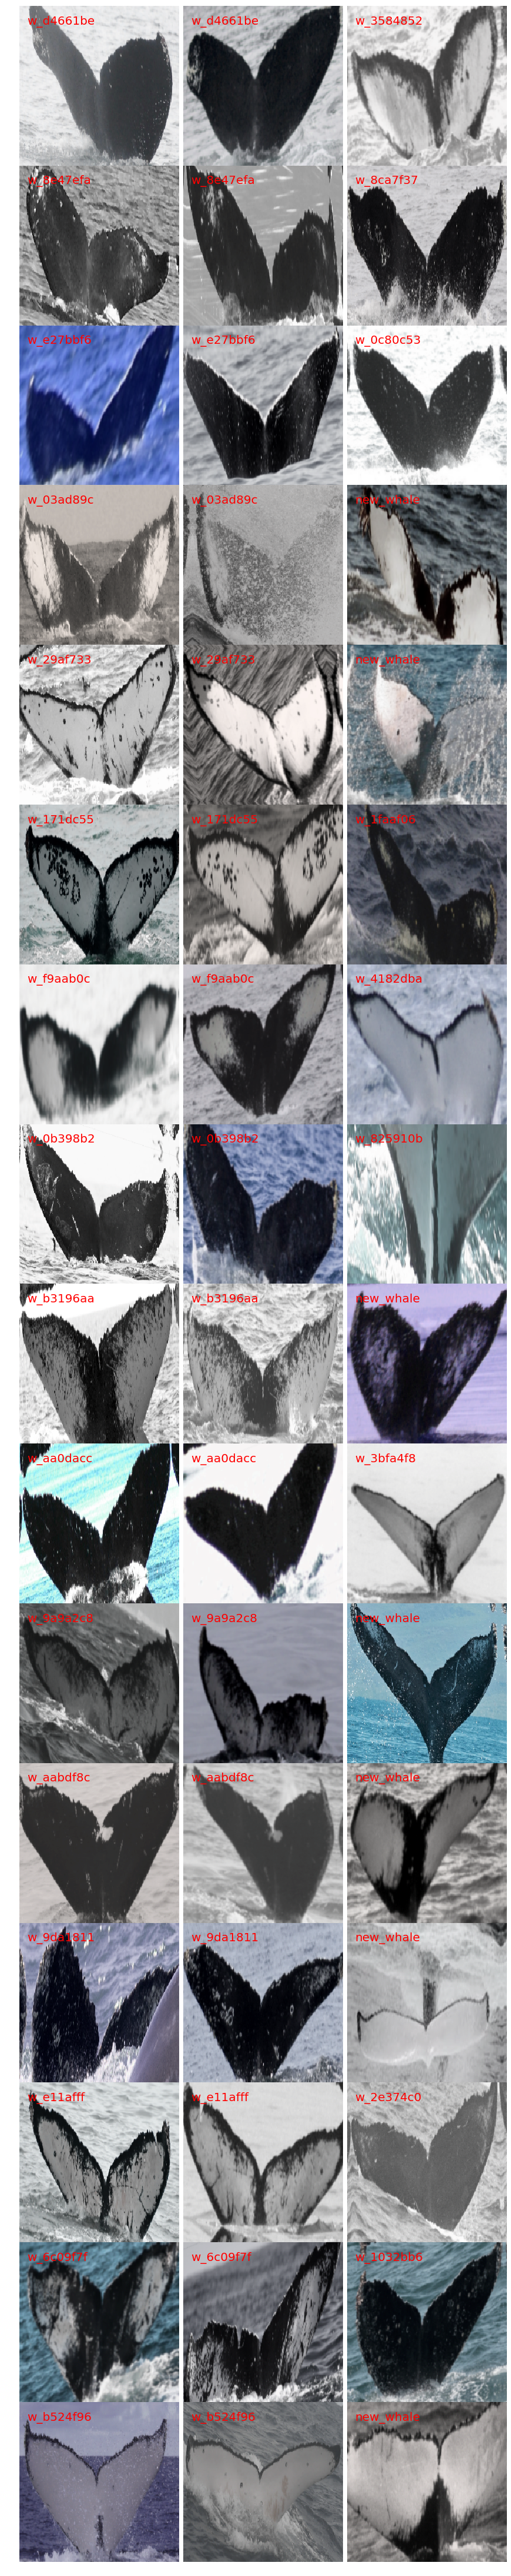

In [8]:
md = get_data(sz,bs)

x,y = next(iter(md.trn_dl))
print(x.shape, y[0].shape)

def display_imgs(x,lbs=None):
    columns = 3
    rows = min(bs,16)
    ig,ax = plt.subplots(rows, columns, figsize=(columns*5, rows*5))
    for i in range(rows):
        for j in range(columns):
            idx = j+i*columns
            ax[i,j].imshow((x[j][i,:,:,:]*255).astype(np.int))
            ax[i,j].axis('off')
            if lbs is not None:
                ax[i,j].text(10, 25, lbs[j][i], size=20, color='red')
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

to_lb = md.trn_ds.names.Id.to_dict()
lbs = [[to_lb[idx] for idx in y_cur.tolist()] for y_cur in y]
display_imgs((md.trn_ds.denorm(x[:,0,:,:,:]),md.trn_ds.denorm(x[:,1,:,:,:]),\
              md.trn_ds.denorm(x[:,2,:,:,:])),lbs)

In [ ]:
class Metric(nn.Module):
    def __init__(self, emb_sz=64):
        super().__init__()   
        self.l = nn.Linear(emb_sz*2,emb_sz*2,False)
        
    def forward(self,d):
        d2 = d.pow(2)
        d = self.l(torch.cat((d,d2),dim=-1))
        x = d.pow(2).sum(dim=-1)
        return x.view(-1)

In [ ]:
def resnext50(pretrained=True):
    model = resnext_50_32x4d()
    name = 'resnext_50_32x4d.pth'
    if pretrained:
        path = os.path.join(MODLE_INIT,name)
        load_model(model, path)
    return model

class TripletResneXt50(nn.Module):
    def __init__(self, pre=True, emb_sz=64, ps=0.5):
        super().__init__()
        encoder = resnext50(pretrained=pre)
        #add DataParallel to allow support of multiple GPUs
        self.cnn = nn.DataParallel(nn.Sequential(encoder[0],encoder[1],nn.ReLU(),
                        encoder[3],encoder[4],encoder[5],encoder[6],encoder[7]))
        self.head = nn.DataParallel(nn.Sequential(AdaptiveConcatPool2d(), Flatten(),
                        nn.Dropout(ps),nn.Linear(4096, 512), nn.ReLU(), 
                        nn.BatchNorm1d(512), nn.Dropout(ps), nn.Linear(512, emb_sz)))
        self.metric = nn.DataParallel(Metric(emb_sz))
        
    def forward(self,x):
        x1,x2,x3 = x[:,0,:,:,:],x[:,1,:,:,:],x[:,2,:,:,:]
        x1 = self.head(self.cnn(x1))
        x2 = self.head(self.cnn(x2))
        x3 = self.head(self.cnn(x3))
        x = torch.cat((x1,x2,x3))
        sz = x.shape[0]
        x1 = x.unsqueeze(1).expand((sz,sz,-1))
        x2 = x1.transpose(0,1)
        #matrix of all vs all differencies
        d = (x1 - x2).view(sz*sz,-1)
        return self.metric(d)
    
    def get_embedding(self, x):
        return self.head(self.cnn(x))
    
    def get_d(self, x0, x):
        d = (x - x0)
        return self.metric(d)
    
class ResNeXt50Model():
    def __init__(self,pre=True,name='TripletResneXt50',**kwargs):
        self.model = to_gpu(TripletResneXt50(pre=True,**kwargs))
        self.name = name

    def get_layer_groups(self, precompute):
        m = self.model.module if isinstance(self.model,FP16) else self.model
        if precompute:
            return [m.head] + [m.metric]
        c = children(m.cnn.module)
        return list(split_by_idxs(c,[5])) + [m.head] + [m.metric]

In [ ]:
def get_densenet169(pre=True):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        layers = cut_model(cut_model(densenet169(pre), -1)[0],-1)
    return nn.Sequential(*layers)

class TripletDenseNet169(nn.Module):
    def __init__(self, pre=True, emb_sz=64, ps=0.5):
        super().__init__()
        encoder = get_densenet169(pre)
        #add DataParallel to allow support of multiple GPUs
        self.cnn = nn.DataParallel(nn.Sequential(encoder[0],encoder[1],nn.ReLU(),
                        encoder[3],encoder[4],encoder[5],encoder[6],encoder[7],
                        encoder[8],encoder[9],encoder[10]))
        self.head = nn.DataParallel(nn.Sequential(AdaptiveConcatPool2d(), Flatten(),
                        nn.Dropout(ps),nn.Linear(3328, 512), nn.ReLU(), 
                        nn.BatchNorm1d(512), nn.Dropout(ps), nn.Linear(512, emb_sz)))
        self.metric = nn.DataParallel(Metric(emb_sz))
        
    def forward(self,x):
        x1,x2,x3 = x[:,0,:,:,:],x[:,1,:,:,:],x[:,2,:,:,:]
        x1 = self.head(self.cnn(x1))
        x2 = self.head(self.cnn(x2))
        x3 = self.head(self.cnn(x3))
        x = torch.cat((x1,x2,x3))
        sz = x.shape[0]
        x1 = x.unsqueeze(1).expand((sz,sz,-1))
        x2 = x1.transpose(0,1)
        #matrix of all vs all differencies
        d = (x1 - x2).view(sz*sz,-1)
        return self.metric(d)
    
    def get_embedding(self, x):
        return self.head(self.cnn(x))
    
    def get_d(self, x0, x):
        d = (x - x0)
        return self.metric(d)
    
class DenseNet169Model():
    def __init__(self,pre=True,name='TripletDenseNet169',**kwargs):
        self.model = to_gpu(TripletDenseNet169(pre=True,**kwargs))
        self.name = name

    def get_layer_groups(self, precompute):
        m = self.model.module if isinstance(self.model,FP16) else self.model
        if precompute:
            return [m.head] + [m.metric]
        c = children(m.cnn.module)
        return list(split_by_idxs(c,[8])) + [m.head] + [m.metric]

In [ ]:
class Contrastive_loss(nn.Module):
    def __init__(self, m=10.0, wd=1e-4):
        super().__init__()
        self.m, self.wd = m, wd
        
    def forward(self, d, target):
        d = d.float()
        #matrix of all vs all comparisons
        t = torch.cat(target)
        sz = t.shape[0]
        t1 = t.unsqueeze(1).expand((sz,sz))
        t2 = t1.transpose(0,1)
        y = ((t1==t2) + to_gpu(torch.eye(sz).byte())).view(-1)
    
        loss_p = d[y==1]
        loss_n = F.relu(self.m - torch.sqrt(d[y==0]))**2
        loss = torch.cat((loss_p,loss_n),0)
        loss = loss[torch.nonzero(loss).squeeze()]
        loss = loss.mean() if loss.shape[0] > 0 else loss.sum()
        loss += self.wd*(d**2).mean() #compactification term
        return loss

#accuracy within a triplet
def T_acc(d, target):
    sz = target[0].shape[0]
    lp = [3*sz*i + i+sz for i in range(sz)]
    ln = [3*sz*i + i+2*sz for i in range(sz)]
    dp, dn = d[lp], d[ln]
    return (dp < dn).float().mean()

#accuracy within a hardest triplet in a batch for each anchor image
def BH_acc(d, target):
    t = torch.cat(target)
    sz = t.shape[0]
    t1 = t.unsqueeze(1).expand((sz,sz))
    t2 = t1.transpose(0,1)
    y = (t1==t2)
    d = d.float().view(sz,sz)
    BH = []
    for i in range(sz):
        dp = d[i,y[i,:] == 1].max()
        dn = d[i,y[i,:] == 0].min()
        BH.append(dp < dn)
    return torch.FloatTensor(BH).float().mean()

In [ ]:
#batch hard loss: https://arxiv.org/pdf/1703.07737.pdf 
class BH_loss(nn.Module):
    def __init__(self, n=1, m=0.0):
        super().__init__()
        self.n = n #select n hardest triplets
        self.m = m
    
    def forward(self, input, target, size_average=True):
        #matrix of all vs all comparisons
        t = torch.cat(target)
        sz = t.shape[0]
        t1 = t.unsqueeze(1).expand((sz,sz))
        t2 = t1.transpose(0,1)
        y = ((t1==t2) + to_gpu(torch.eye(sz).byte()))
        d = input.float().view(sz,sz)
        D = []
        for i in range(2*sz//3):
            dp = d[i,y[i,:] == 1].max()
            dn = d[i,y[i,:] == 0]
            dist, idxs = torch.sort(dn)
            n = min(self.n,dn.shape[0])
            for j in range(n):
                D.append((self.m + dp - dn[idxs[j]]).unsqueeze(0))
        loss = torch.log1p(torch.exp(torch.cat(D)))
        loss = loss.mean() if size_average else loss.sum()
        return loss


In [ ]:
learner = ConvLearner(md,DenseNet169Model(ps=0.0,emb_sz=n_embedding))
learner.opt_fn = optim.Adam
learner.clip = 1.0 #gradient clipping
learner.crit = Contrastive_loss()
learner.metrics = [T_acc,BH_acc]
learner.freeze_to(-2) #unfreez metric and head block
learner #click "output" to see details of the model

TripletDenseNet169(
  (cnn): DataParallel(
    (module): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True

In [ ]:
import warnings 
warnings.filterwarnings('ignore')

 69%|██████▉   | 177/257 [02:53<01:25,  1.07s/it, loss=42.5]

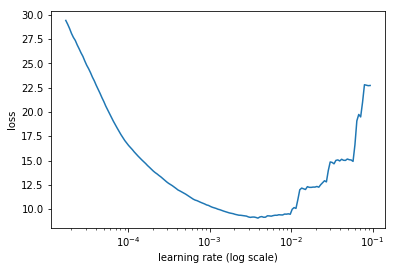

In [ ]:
learner.lr_find()
learner.sched.plot()

In [ ]:
lr = 1e-3
learner.fit(lr,1)

epoch      trn_loss   val_loss   T_acc      BH_acc          
    0      6.234925   6.50087    0.865712   0.471203  


[6.500869887581657, 0.8657117274689056, 0.4712026253702818]

In [ ]:
learner.unfreeze() #unfreeze entire model
lrs=np.array([lr/10,lr/3,lr,lr])
learner.half() #half precision

In [ ]:
learner.fit(lrs/2,4,cycle_len=1,use_clr=(10,20))
learner.fit(lrs/4,4,cycle_len=2,use_clr=(10,20))
learner.save('model0')

epoch      trn_loss   val_loss   T_acc      BH_acc          
    0      5.379147   5.288835   0.969561   0.79618   
 65%|██████▍   | 167/257 [03:03<01:38,  1.09s/it, loss=5.42]

In [ ]:
def extract_embedding(model,path):
    tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO)
    tfms[0].tfms = [tfms[0].tfms[2],tfms[0].tfms[3]]
    tfms[1].tfms = [tfms[1].tfms[2],tfms[1].tfms[3]]
    ds = ImageData.get_ds(FilesDataset_single, (None,TRAIN), (None,TRAIN),
         tfms, test=(None,path))
    md = ImageData(PATH, ds, 3*bs, num_workers=nw, classes=None)
    model.eval()
    with torch.no_grad():
        preds = torch.zeros((len(md.test_dl.dataset), n_embedding))
        start=0
        for i, (x,y) in tqdm_notebook(enumerate(md.test_dl,start=0),
                                       total=len(md.test_dl)):
            size = x.shape[0]
            m = model.module if isinstance(model,FP16) else model
            preds[start:start+size,:] = m.get_embedding(x.half())
            start+= size
        return preds, [os.path.basename(name) for name in md.test_dl.dataset.fnames]

In [ ]:
emb, names = extract_embedding(learner.model,TRAIN)
df = pd.DataFrame({'files':names,'emb':emb.tolist()})
df.emb = df.emb.map(lambda emb: ' '.join(list([str(i) for i in emb])))
df.to_csv('train_emb0.csv', header=True, index=False)

emb, names = extract_embedding(learner.model,TEST)
df_test = pd.DataFrame({'files':names,'emb':emb.tolist()})
df_test.emb = df_test.emb.map(lambda emb: ' '.join(list([str(i) for i in emb])))
df_test.to_csv('test_emb0.csv', header=True, index=False)

In [ ]:
def get_nbs(model,x,y,n=16):
    d, idxs = [], []
    sz = x.shape[0]
    model.eval()
    with torch.no_grad():
        m = model.module if isinstance(model,FP16) else model
        m = m.module if isinstance(m,nn.DataParallel) else m
        for i in tqdm_notebook(range(sz)):
            preds = m.get_d(x[i],y)
            sorted, indices = torch.sort(preds)
            d.append(to_np(sorted[:n]))
            idxs.append(to_np(indices[:n]))
    return np.stack(d), np.stack(idxs)

def get_val_nbs(model,emb_df,out='val.csv',dcut=None):
    emb_df = emb_df.copy()
    data = pd.read_csv(LABELS).set_index('Image')
    emb_df['emb'] = [[float(i) for i in s.split()] for s in emb_df['emb']]
    emb_df.set_index('files',inplace=True)
    train_df = data.join(emb_df)
    train_df = train_df.reset_index()
    #the split should be the same as one used for training
    trn_df, val_df = train_test_split(train_df,test_size=0.2, random_state=42)
    trn_preds = np.array(trn_df.emb.tolist())
    val_preds = np.array(val_df.emb.tolist())
    trn_df = trn_df.reset_index()
    val_df = val_df.reset_index()
    
    trn_preds = torch.from_numpy(trn_preds).half().cuda()
    val_preds = torch.from_numpy(val_preds).half().cuda()
    trn_d,trn_idxs = get_nbs(model,val_preds,trn_preds)
    
    s = []
    for l1 in trn_d.tolist():
        s.append(' '.join([str(l2) for l2 in l1]))
    val_df['d'] = s
    val_df['nbs'] = [' '.join(trn_df.loc[trn_idxs[index]].Id.tolist()) \
                     for index, row in val_df.iterrows()]
    val_df[['Image','Id','nbs','d']].to_csv(out, header=True, index=False)
    
    if dcut is not None:
        scores = []
        for idx in val_df.index:
            l0 = val_df.loc[idx].Id
            nbs = dict()
            for i in range(16): #16 neighbors
                nb = trn_idxs[idx,i]
                l, s = trn_df.loc[nb].Id, trn_d[idx,i]
                if s > dcut and 'new_whale' not in nbs: nbs['new_whale'] = dcut
                if l not in nbs: nbs[l] = s
                if len(nbs) >= 5: break
            nbs_sorted = list(nbs.items())
            score = 0.0
            for i in range(min(len(nbs),5)):
                if nbs_sorted[i][0] == l0:
                    score = 1.0/(i + 1.0)
                    break
            scores.append(score)
        print(np.array(scores).mean(), flush=True)
dcut = 20.0 #fit this parameter based on validation
get_val_nbs(learner.model,df,dcut=dcut,out='val0.csv')

In [ ]:
def get_test_nbs(model,trn_emb,test_emb,out='test.csv',\
                 submission='submission.csv',dcut=None):
    trn_emb = trn_emb.copy()
    data = pd.read_csv(LABELS).set_index('Image')
    trn_emb['emb'] = [[float(i) for i in s.split()] for s in trn_emb['emb']]
    trn_emb.set_index('files',inplace=True)
    train_df = data.join(trn_emb)
    train_df = train_df.reset_index()
    train_preds = np.array(train_df.emb.tolist())
    test_emb = test_emb.copy()
    test_emb['emb'] = [[float(i) for i in s.split()] for s in test_emb['emb']]
    test_emb['Image'] = test_emb['files']
    test_emb.set_index('files',inplace=True)
    test_df = test_emb.reset_index()
    test_preds = np.array(test_df.emb.tolist())
    train_preds = torch.from_numpy(train_preds).half().cuda()
    test_preds = torch.from_numpy(test_preds).half().cuda()
    test_d,test_idxs = get_nbs(model,test_preds,train_preds)
    
    s = []
    for l1 in test_d.tolist():
        s.append(' '.join([str(l2) for l2 in l1]))
    test_df['d'] = s
    test_df['nbs'] = [' '.join(train_df.loc[test_idxs[index]].Id.tolist()) \
                      for index, row in test_df.iterrows()]
    test_df[['Image','nbs','d']].to_csv(out, header=True, index=False)
    
    if dcut is not None:
        pred = []
        for idx, row in test_df.iterrows():
            nbs = dict()
            for i in range(0,16):
                nb = test_idxs[idx,i]
                l, s = train_df.loc[nb].Id, test_d[idx,i]
                if s > dcut and 'new_whale' not in nbs: nbs['new_whale'] = dcut
                if l not in nbs: nbs[l] = s
                if len(nbs) >= 5: break
            nbs_sorted = list(nbs.items())
            p = ' '.join([lb[0] for lb in nbs_sorted])
            pred.append({'Image':row.files,'Id':p})
        pd.DataFrame(pred).to_csv(submission,index=False)

In [ ]:
get_test_nbs(learner.model,df,df_test,dcut=dcut,out='test0.csv',\
    submission='submission0.csv')